# Pipeline for High-z Radio Galaxies 25: Create lists (files) with radio AGN candidates

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
# import schemdraw
# from schemdraw import flow

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [12]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [13]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [14]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [15]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [16]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

---

## Reading data

In [17]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [18]:
save_plot_flag      = False
save_preds_flag     = True
load_models_flag    = True
use_second_z_model  = True  # z >= 2.0
use_third_z_model   = True  # z >= 3.0
use_fourth_z_model  = True  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [19]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'

In [20]:
if used_area != 'S82':
    compare_A17_flag = False

In [21]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [22]:
# feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
# feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
# feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [23]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [24]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [25]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [26]:
full_catalog_df['radio_AGN']      = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

Discard minor features.

In [27]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [28]:
seed                                = 42

---

### Load models

In [29]:
if load_models_flag:
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model('models/regression_z_may_18_2022')  # to use on sources with predicted z >= 2
    if use_third_z_model:
        redshift_reg_3  = pyr.load_model('models/regression_z_may_30_2022')  # to use on sources with predicted z >= 3
    if use_fourth_z_model:
        # redshift_reg_4  = pyr.load_model('models/regression_z_may_31_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        redshift_reg_4  = pyr.load_model('models/regression_z_may_31_4_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        # redshift_reg_4  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [30]:
threshold_AGN   = 0.3112  # 0.5, 0.3094 from ROC AUC in train+test, 0.3112 from PR curve
threshold_radio = 4.99972232e-01  # 0.5, 4.99972232e-01 from ROC AUC in train+test and PR curve

In [31]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=7)

In [32]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=7)

In [33]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [34]:
redshift_lim_a    = 2.0
redshift_tol_a    = 0.0
redshift_lim_b    = 3.0
redshift_tol_b    = 0.0
redshift_lim_c    = 4.0  # 3.7, 4.0
redshift_tol_c    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=3)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_a + redshift_tol_a)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)
if use_third_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_3, data=full_catalog_df, round=3)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_b + redshift_tol_b)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)
if use_fourth_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_4, data=full_catalog_df, round=3)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_c + redshift_tol_c)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

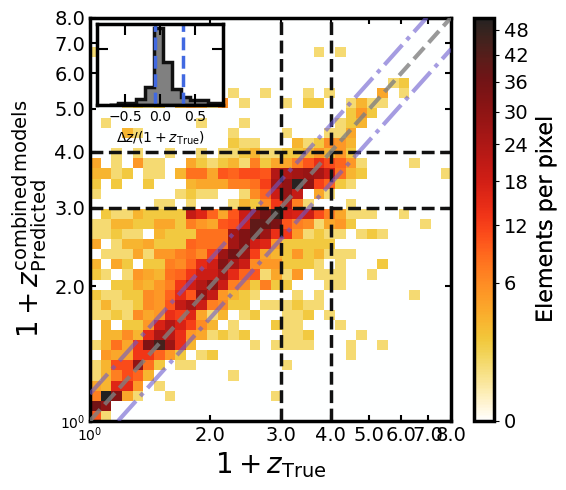

In [35]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axvline(x=(1 + redshift_lim_b), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_b), ls='--', c='k', lw=2.5)
if use_second_z_model or use_third_z_model or use_fourth_z_model:
    ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

In [36]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'Score_radio']
rad_score_scaler                      = MinMaxScaler()
full_catalog_df['scaled_score_radio'] = rad_score_scaler.fit_transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [37]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,369093.000000,369093.000000,369093.000000,369093.000000,3514.000000,369093.000000
mean,0.488563,0.635853,0.042835,0.260848,1.284949,2.113896
std,0.098904,0.481191,0.202485,0.439098,0.890670,1.071312
min,0.000000,0.000000,0.000000,0.000000,-0.002420,0.040000
25%,0.500000,0.000000,0.000000,0.000000,0.580100,1.431000
50%,0.500000,1.000000,0.000000,0.000000,1.166000,1.982000
75%,0.500000,1.000000,0.000000,1.000000,1.874500,2.563000
max,1.000000,1.000000,1.000000,1.000000,6.780000,6.210000


Obtain intermediate metrics

In [38]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [39]:
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN']          >= threshold_AGN) &\
#                             np.array(full_catalog_df.loc[:, 'Score_radio']      >= threshold_radio)
filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'pred_class']      == 1) &\
                            np.array(full_catalog_df.loc[:, 'pred_radio']    == 1)
filt_hiz_rAGN_p         = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= redshift_lim_c)
filter_AGN_p            = np.array(full_catalog_df.loc[:, 'pred_class']      == 1)
filter_radio_p          = np.array(full_catalog_df.loc[:, 'pred_radio']      == 1)
num_AGN_p               = np.sum(filter_AGN_p)
num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0))
num_radio_p             = np.sum(filter_radio_p)
num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

### Select sources predicted to be Radio AGN

In [40]:
full_catalog_df         = full_catalog_df.loc[filter_radio_AGN_p]

In [41]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,34665.000000,34665.0,34665.000000,34665.0,1021.000000,34665.000000
mean,0.499639,1.0,0.108380,1.0,1.014643,1.586028
std,0.121918,0.0,0.310864,0.0,0.832285,0.811113
min,0.000000,1.0,0.000000,1.0,-0.002420,0.040000
25%,0.500000,1.0,0.000000,1.0,0.344000,1.055000
50%,0.500000,1.0,0.000000,1.0,0.841000,1.422000
75%,0.500000,1.0,0.000000,1.0,1.479000,1.898000
max,1.000000,1.0,1.000000,1.0,5.469000,6.210000


Add individual metrics for redshift

In [42]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [43]:
str_0_t   = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t   = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t   = f'{num_AGN_t:,} are confirmed to be AGN. And, from the AGN,\n'
str_3_t   = f'{num_radio_AGN_t:,} are detected in radio.'

str_0_p   = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p   = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p   = f'{num_AGN_p:,} are predicted to be AGN. And, from the predicted AGN,\n'
str_3_p   = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

In [44]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)

------------------------------------------------------------
Out of 369,093 initial sources in S82,
11,539 are confirmed to be galaxies. On the other side,
3,096 are confirmed to be AGN. And, from the AGN,
1,163 are detected in radio.
------------------------------------------------------------
Out of 1,163 initial radio-detected AGN in S82,
134,404 are predicted to be galaxies. On the other side,
234,689 are predicted to be AGN. And, from the predicted AGN,
34,665 are predicted to be detected in radio.
------------------------------------------------------------


In [45]:
cols_4_table = show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                               'radio_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

In [46]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = cols_4_table + cols_4_exp_all[used_area] + cols_photo

In [47]:
filter_new_rAGN = full_catalog_df.loc[:, 'radio_AGN'] == 0
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= 4.5

In [48]:
full_catalog_df.loc[:, 'TYPE'] = full_catalog_df.loc[:, 'TYPE'].mask(full_catalog_df.loc[:, 'TYPE'] == '    ', 'CCCC')

In [49]:
display(full_catalog_df.loc[filter_high_z, cols_4_export].sort_values(by=['pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z,Total_flux_VLASS,Fint_VLAS82,Stotal_TGSS,FEP,W1mproPM,W2mproPM,gmag,rmag,imag,zmag,ymag,FUVmag,NUVmag,Jmag,Hmag,Kmag,W3mag,W4mag
264397,J231833.98+005809.5,349.641602,0.969328,CCCC,7,0.5,1,0.385986,0,1,0.582962,0.225015,NaN,6.21,15.21,17.860001,11.18,57.900002,19.760000,19.809999,23.299999,23.200001,23.100000,21.309999,21.400000,20.0,21.0,17.450001,17.24,16.59,16.670,14.620
362815,J010348.98-004755.3,15.954120,-0.798716,CCCC,7,0.5,1,0.518748,0,1,0.587868,0.304956,NaN,6.21,15.21,17.860001,11.18,57.900002,19.851999,19.809999,23.299999,23.200001,23.100000,21.498100,21.400000,20.0,21.0,17.450001,17.24,16.59,16.670,14.620
166030,J012701.54+000619.7,21.756475,0.105492,CCCC,7,0.5,1,0.649834,0,1,0.599019,0.389263,NaN,6.21,15.21,17.860001,11.18,57.900002,19.667000,19.705000,23.299999,23.200001,23.100000,21.574800,21.400000,20.0,21.0,17.450001,17.24,16.59,16.670,14.620
63730,J231614.11-011655.4,349.058807,-1.282086,CCCC,7,0.5,1,0.519250,0,1,0.502676,0.261015,NaN,6.21,15.21,17.860001,11.18,57.900002,19.790998,19.809999,23.299999,23.200001,23.100000,21.467699,21.400000,20.0,21.0,17.450001,17.24,16.59,16.670,14.620
334960,J014627.45+000531.0,26.614408,0.091951,CCCC,4,0.5,1,0.372474,0,1,0.580285,0.216141,NaN,5.80,15.21,17.860001,11.18,57.900002,19.658998,19.809999,23.299999,23.200001,22.387400,21.355400,21.400000,20.0,21.0,17.450001,17.24,16.59,16.670,14.620
119957,J005058.65-002628.4,12.744381,-0.441237,CCCC,10,0.5,1,0.330339,0,1,0.551740,0.182261,NaN,5.80,15.21,17.860001,11.18,57.900002,19.133999,19.530001,23.299999,22.112900,20.293501,19.408501,18.926800,20.0,21.0,17.450001,17.24,16.59,16.670,14.620
246986,J225034.64-001459.0,342.644409,-0.249751,CCCC,9,0.5,1,0.343430,0,1,0.644960,0.221499,NaN,5.80,15.21,17.860001,11.18,57.900002,19.223000,19.673000,23.299999,22.052601,20.044300,19.243799,18.666201,20.0,21.0,17.450001,17.24,16.59,16.670,14.524
325275,J221842.28-004913.0,334.676208,-0.820283,CCCC,8,0.5,1,0.316249,0,1,0.594558,0.188029,NaN,5.80,15.21,17.860001,11.18,57.900002,20.025999,19.809999,23.299999,21.411501,23.100000,21.212000,21.400000,20.0,21.0,17.450001,17.24,16.59,16.573,14.620
208073,J222129.35+005647.8,335.372314,0.946608,CCCC,9,0.5,1,0.351127,0,1,0.607493,0.213307,NaN,5.80,15.21,17.860001,11.18,57.900002,19.455000,19.307001,23.299999,23.200001,21.655300,20.832500,20.656000,20.0,21.0,17.450001,17.24,16.59,16.670,14.620
363100,J231239.46+002512.7,348.164429,0.420203,CCCC,9,0.5,1,0.329121,0,1,0.599019,0.197150,NaN,5.80,15.21,17.860001,11.18,57.900002,19.507000,19.566000,23.299999,23.200001,21.895800,21.093399,20.801500,20.0,21.0,17.450001,17.24,16.59,16.670,14.620


In [50]:
if save_preds_flag:
    full_catalog_df.loc[filter_high_z, cols_4_export].sort_values(by=['pred_Z'], ascending=False).to_csv(f'pred_rAGN/predicted_rAGN_{used_area}.csv')

---